<a href="https://colab.research.google.com/github/OD1992/Python-programs/blob/main/Hospi_change_point.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

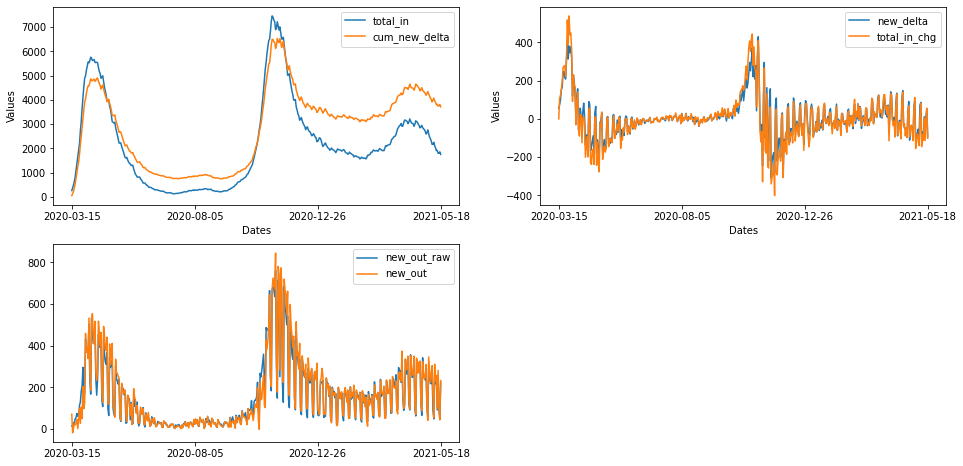

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
#import datetime
#import time

#confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
#confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
#deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
#deaths = pd.read_csv(deaths_url, sep=',')
#path_to_save = ''
#confirmed_cases
#data_end   = '5/15/20' #Take the data until yesterday
#data_begin = '3/15/20'
#cases_obs = np.array(confirmed_cases.loc[confirmed_cases["Country/Region"] == "Belgium", data_begin:data_end])[0]
#dates=confirmed_cases.loc[confirmed_cases["Country/Region"] == "Belgium", data_begin:data_end].columns
#np.array(dates)

#*******************************************************************************************************
#********* We decide to work with Hospi data in order to show the evolution of beta and identigy the change point
#**************Meeting between Niko, PA and me on 12/12/2022
#Horpitalizations data in Belgium
import copy
from datetime import datetime   # useful for date ranges in plots

sw_dataset = 'BEL'  # !! Default: 'BEL'. Currently 'BEL' and 'FRA' are available.
sw_districts = 'sum'  # !! Default: 'sum'. If 'sum', sums over all districts (i.e., provinces, departments...). If 'each', loop over all districts. sw_districts can also be the name of a district (for example, sw_districts = 'Brussels', or sw_districts = '75' for Paris, or sw_districts = 'London').  # PATODO fix London and stuff.
# ***********************************************************************************
# Load data Belgium
# *******   
# The data comes from https://epistat.sciensano.be/Data/COVID19BE_HOSP.csv.
# This link was provided on 22 June 2020 by Alexey Medvedev on the "Re R0 estimation" channel of the O365G-covidata team on MS-Teams.
# The link can be reached from https://epistat.wiv-isp.be/covid/
# Some explanations can be found at https://epistat.sciensano.be/COVID19BE_codebook.pdf
data_url='/COVID19BE_HOSP_2021-05-16.csv'
data_raw = pd.read_csv(data_url)  # !! changed:21PA
#fields = ['DATE', 'NR_REPORTING', 'TOTAL_IN','TOTAL_IN_ICU','TOTAL_IN_RESP','TOTAL_IN_ECMO','NEW_IN','NEW_OUT']

if sw_districts == 'each':
    data_groupbydistrict = pd.DataFrame(data_raw.groupby("PROVINCE"))
if sw_districts == 'sum':
    nb_districts = 1
elif sw_districts == 'each':
    nb_districts = len(data_groupbydistrict)
else:  # else nb_districts is the name of a district
    nb_districts = 1
    
if nb_districts > 2:
    show_figures = 0  # Force figures off if there are too many districts

for cnt_district in range(nb_districts):

    if sw_districts == 'sum':
        district_name = 'sum'
        district_names = np.array(['sum'])   # without np.array, we get an error in district_names[medians_argsort]
    elif sw_districts == 'each':
        district_name = data_groupbydistrict[0][cnt_district]
        district_names = data_groupbydistrict[0]
    else:
        district_name = sw_districts
        district_names = np.array([sw_districts])

    # ***********************************************************************************
    # Process data Belgium
    # *******
    
    if sw_districts == 'sum':
        data_raw_district = data_raw.groupby('DATE', as_index=False).sum()  # sum over provinces
    elif sw_districts == 'each':
        data_raw_district = data_groupbydistrict[1][cnt_district]  # extract province cnt_district
    else:   
        data_raw_district = data_raw[data_raw.iloc[:,1]==sw_districts].reset_index(drop=True)   # extract district with name sw_districts

    data = data_raw_district[['DATE', 'NR_REPORTING', 'TOTAL_IN','TOTAL_IN_ICU','TOTAL_IN_RESP','TOTAL_IN_ECMO','NEW_IN','NEW_OUT']]  # exclude some useless columns
        
    # Extract relevant data and recompute new_out:
    # Source: Some variable names taken from https://rpubs.com/JMBodart/Covid19-hosp-be
    data_length = np.size(data,0)
    data_num = data.iloc[:,1:].to_numpy(dtype=float)  # extract all rows and 2nd--last columns (recall that Python uses 0-based indexing) and turn it into a numpy array of floats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

    #dates = data['DATE'])
    dates_raw = copy.deepcopy(data['DATE'])
    dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
    Dates = [None] * data_length
    for i in range(0,data_length):
        Dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

    col_total_in = 1
    col_new_in = 5
    col_new_out = 6
    total_in = data_num[:,col_total_in]
    new_in = data_num[:,col_new_in]
    new_out_raw = data_num[:,col_new_out] # there will be a non-raw due to the "Problem" mentioned below.
    new_delta = new_in - new_out_raw
    cum_new_delta = np.cumsum(new_delta)
    total_in_chg = np.hstack(([0],np.diff(total_in))) #difference between x[i+1]-x[i]
    # Problem: new_delta and total_in_chg are different, though they are sometimes close. 
    # Cum_new_delta does not go back to something close to zero, whereas it should. Hence I should not trust it.
    # I'm going to trust total_in and new_in. I deduce new_out_fixed by:
    new_out = new_in - total_in_chg   # fixed new_out
    data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns

    # Show Belgian data in figures:
    nb_xticks = 4
    dates_ticks = [None] * nb_xticks
    dates_ticks_ind = np.linspace(0,len(total_in)-1,nb_xticks,dtype=int)
    for i in range(0,nb_xticks):
        dates_ticks[i] = Dates[dates_ticks_ind[i]]

    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    plt.plot(Dates, total_in)
    plt.plot(Dates,cum_new_delta)
    plt.xticks(dates_ticks)
    plt.xlabel("Dates")
    plt.ylabel("Values")
    plt.legend(("total_in","cum_new_delta"))
    #plt.ylim([0,1000])

    plt.subplot(2,2,2)
    plt.plot(Dates,new_delta)
    plt.plot(Dates,total_in_chg)
    plt.xticks(dates_ticks)
    plt.xlabel("Dates")
    plt.ylabel("Values")
    plt.legend(("new_delta","total_in_chg"))

    plt.subplot(2,2,3)
    plt.plot(Dates,new_out_raw)
    plt.plot(Dates,new_out)
    plt.xticks(dates_ticks)
    plt.legend(("new_out_raw","new_out"))

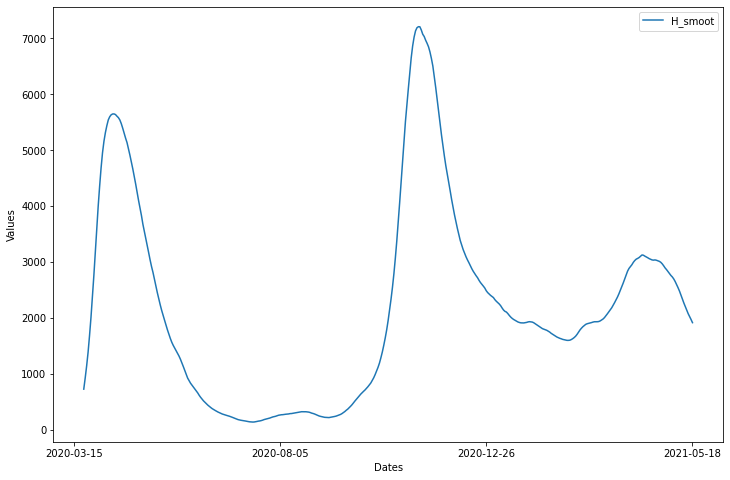

In [2]:
#Calculate and show the H_smooth with Moving Average method
N = 7  # The window length of moving average will be 2N+1.
H_smooth_MA = total_in * np.nan  # MA: moving average
for t in np.arange(7, len(total_in)):
    H_smooth_MA[t] = np.mean(total_in[t-N:t])

nb_xticks = 4
dates_ticks = [None] * nb_xticks
dates_ticks_ind = np.linspace(0,len(total_in)-1,nb_xticks,dtype=int)
for i in range(0,nb_xticks):
    dates_ticks[i] = Dates[dates_ticks_ind[i]]

plt.figure(figsize=(12,8))
plt.plot(Dates, H_smooth_MA, label="H_smoot")
plt.xticks(dates_ticks)
plt.xlabel("Dates")
plt.ylabel("Values")
plt.legend()
plt.show()

/usr/local/lib/python3.8/dist-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/lib/python3.8/dist-packages/scipy/optimize/minpack.py:792: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)


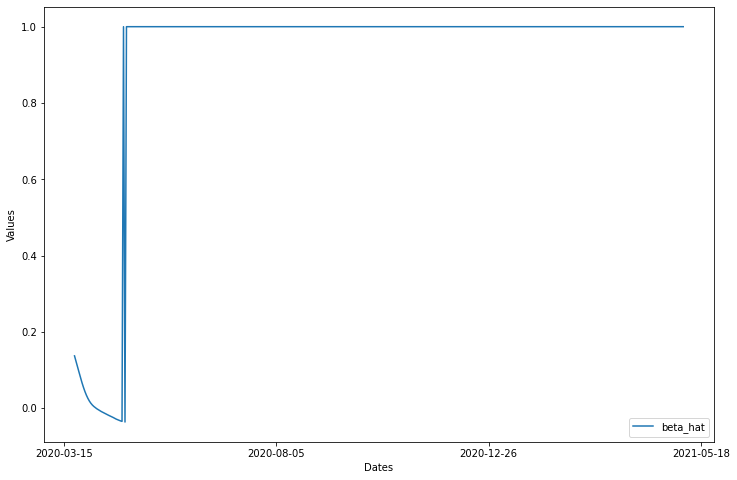

In [3]:
H_smooth_MA = H_smooth_MA[7:]
from scipy import optimize
# let's define the function form
def func(x, H_init, beta_effective):
    #Note: beta_effective = beta-gamma
    y = H_init* np.exp(beta_effective*x)
    return y

d=5; beta_effective = 0.23
t_i =7; t_e = len(H_smooth_MA)-d
beta_effective_opt = np.full(t_e, np.nan)
H_init_opt = np.full(t_e, np.nan)

for t in np.arange(t_i, t_e):
    H_init= H_smooth_MA[t-d]
    x = np.arange(t-d, t+d)
    y = H_smooth_MA[t-d:t+d]
    H_init_opt[t], beta_effective_opt[t] = optimize.curve_fit(func, xdata = x, ydata = y)[0]
    #print(f'H_init_opt={H_init_opt[t]},  beta_effective_opt={beta_effective_opt[t]}')

plt.figure(figsize=(12,8))
plt.plot(Dates[t_i:t_e], beta_effective_opt[t_i:t_e], label="beta_hat")
plt.xticks(dates_ticks)
plt.xlabel("Dates")
plt.ylabel("Values")
plt.legend()
plt.show()
